# Sudoku solver

In classic Sudoku, the objective is to fill a 9 × 9 grid with digits so that each column, each row, and each of the nine 3 × 3 subgrids that compose the grid (also called "boxes", "blocks", or "regions") contains all of the digits from 1 to 9.

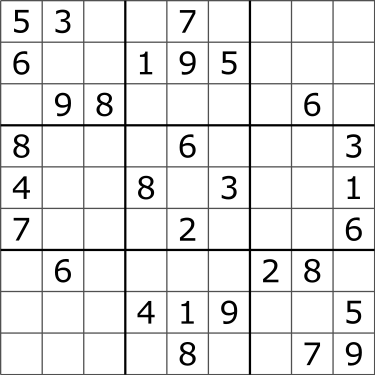

## Prepare environment

In [1]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

project_root = os.getcwd()
src_dir = os.path.join(project_root, "src")
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

from sudoku_solver.data.dataset import prepare_dataset
from sudoku_solver.data.preprocess import preprocess_input, preprocess_target
from sudoku_solver.model.model import prepare_model
from sudoku_solver.model.training import prepare_callbacks
from sudoku_solver.model.evaluation import plot_histories

import numpy as np
import tensorflow as tf
import keras

# Uncomment for debugging
# tf.config.run_functions_eagerly(True)

# Enable mixed precision training to speed up computation
# WARNING: turn off if you run this on CPU - it will significantly slow down training
# https://keras.io/api/mixed_precision/
#
# Enable when training takes too long - it lowered training time by 14% and increased error rate by 16%
keras.mixed_precision.set_global_policy("mixed_float16")

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# tf.config.experimental.enable_op_determinism()

MODEL_FILE_NAME = "sudoku_solver.keras"

E0000 00:00:1746551453.722631  263536 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746551453.734775  263536 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Hyperparameters

In [2]:
# We need to limit data to be able to run faster experiments
DATA_SIZE_LIMIT = 200_000

BATCH_SIZE = 256 # Best accurracy & time for current learning rate
LEARNING_RATE = 1e-3
EPOCHS = 3

# Use residual connections in convolutional model architecture
USE_RESIDUAL = True

# Idea is to pretrain model on solution-only data (self-supervised learning) like autoencoder
#
# Note: There is no performance improvement on small data sample (10%) and few epochs training (1)
# Turn on when training with more data and epochs to see if it helps
USE_PRE_TRAINING = False

# Disk cache is slower but a must if we can't load everything into a memory
USE_DISK_CACHE = False

# Idea is to let model learn first on easy problems and then gradually increase problem difficulty
USE_CURRICULUM_LEARNING = True

# Idea is to create a layer that would penalise predictions that break Sudoku rules
CONSTRAINT_WEIGHT = 0.1

# Fixed cell penalty only makes sense if we increase weight against cross-entropy,
# otherwise we could just use cross-entropy to check fixed number predictions
FIXED_CELL_WEIGHT = 10

# Replace predictions for fixed numbers with actuall fixed numbers
#
# Idea is to force model to ignore fixed numbers
#
# Note: so far it seems that model is unable to learn with this turned on
USE_FIXED_NUMBER_LAYER = False

## Prepare dataset

In [3]:
train_datasets, val_dataset, test_dataset = prepare_dataset(BATCH_SIZE, size_limit=DATA_SIZE_LIMIT, use_disk_cache=USE_DISK_CACHE)

Trying to prepare dataset from disk


I0000 00:00:1746551460.515335  263536 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


Dataset ready.


Measuring pipeline performance...:   7%|▋         | 74/1000 [00:00<00:11, 77.41it/s]

Average batch fetch time is: 0.02793419361114502


In [4]:
print("Validate dataset pipeline:\n")
for X_batch, y_batch in train_datasets[0].take(1):
    for X, y in zip(X_batch, y_batch):
        # TODO: can't we reuse this conversion back to readable Sudoku puzzle? (e.g. invert operation)
        print(((X + 0.5) * 9).numpy().reshape((9, 9)).astype(int))
        print((y + 1).numpy().reshape((9, 9)))
        break

Validate dataset pipeline:

[[1 4 9 7 2 5 3 8 6]
 [0 0 5 3 9 8 1 4 7]
 [7 3 8 4 1 6 9 5 2]
 [8 7 3 9 6 2 4 0 5]
 [0 6 4 1 5 3 7 9 8]
 [5 9 0 0 4 7 6 2 3]
 [3 1 7 0 8 9 2 6 4]
 [4 0 2 6 3 1 5 7 9]
 [9 0 0 2 0 4 8 3 1]]
[[ 1  4  9  7  2  5  3  8  6]
 [16 12  5  3  9  8  1  4  7]
 [ 7  3  8  4  1  6  9  5  2]
 [ 8  7  3  9  6  2  4 11  5]
 [12  6  4  1  5  3  7  9  8]
 [ 5  9 11 18  4  7  6  2  3]
 [ 3  1  7 15  8  9  2  6  4]
 [ 4 18  2  6  3  1  5  7  9]
 [ 9 15 16  2 17  4  8  3  1]]


In [5]:
train_batch_size = sum(1 for _ in train_datasets[0])
train_batch_size

74

## Train model

### Prepare model

In [6]:
model = prepare_model(
    use_residual=USE_RESIDUAL,
    use_fixed_number_layer=USE_FIXED_NUMBER_LAYER,
    learning_rate=LEARNING_RATE,
    constraint_weight=CONSTRAINT_WEIGHT,
    fixed_cell_weight=FIXED_CELL_WEIGHT,
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 9, 9, 1)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 64)  │        640 │ cast[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 9, 9, 64)  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9, 9, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 64)  │     36,928 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 9, 9, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 9, 9, 64)  │          0 │ add_1[0][0]     

 Total params: 7,944,713 (30.31 MB)

 Trainable params: 7,943,049 (30.30 MB)

 Non-trainable params: 1,664 (6.50 KB)

### Train

In [7]:
#TODO: move to dataset.py
TEST_TRAIN_SPLIT = 0.05

PRIMARY_DATASET_SPLIT = 0.7

def prepare_train_dataset(train_datasets, main_dataset_index):
    mixed_dataset = []
    for dataset_index, dataset in enumerate(train_datasets):
        if (dataset_index == main_dataset_index):
            split = PRIMARY_DATASET_SPLIT
        else:
            split = (1 - PRIMARY_DATASET_SPLIT) / 9
        
        dataset_size = len(dataset)
        split_size = int(dataset_size * split)
        partial_dataset = dataset.take(split_size)

        if (mixed_dataset):
            mixed_dataset = mixed_dataset.concatenate(partial_dataset)
        else:
            mixed_dataset = partial_dataset

    return mixed_dataset.shuffle(int(dataset_size))

In [8]:
histories = []
initial_epoch = 0
for main_dataset_index in range(len(train_datasets)):
    training_callbacks = prepare_callbacks()

    train_dataset = prepare_train_dataset(train_datasets, main_dataset_index)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=initial_epoch + EPOCHS,
        callbacks=training_callbacks,
        initial_epoch=initial_epoch
    )
    histories.append(history)

    initial_epoch += EPOCHS

Epoch 1/3


I0000 00:00:1746551474.630393  263653 service.cc:148] XLA service 0x7f827c0089b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746551474.630447  263653 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
W0000 00:00:1746551474.756644  263653 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1746551475.932577  263653 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1746551493.455468  263653 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.0849 - box_penalty: 0.2421 - col_penalty: 0.2417 - loss: 9.4328 - row_penalty: 0.2466

W0000 00:00:1746551503.271101  263653 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert



Penalties:
crossentropy_tracker:  tf.Tensor(1.0129737, shape=(), dtype=float32)
total_penalty_tracker:  tf.Tensor(0.042517964, shape=(), dtype=float32)
row_penalty_tracker:  tf.Tensor(0.1437826, shape=(), dtype=float32)
col_penalty_tracker:  tf.Tensor(0.14037393, shape=(), dtype=float32)
box_penalty_tracker:  tf.Tensor(0.14102298, shape=(), dtype=float32)
cell_penalty_tracker:  tf.Tensor(7.903091, shape=(), dtype=float32)
0 <Variable path=constraint_weight, shape=(), dtype=float32, value=0.10000000149011612>
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 201ms/step - accuracy: 0.0851 - box_penalty: 0.2411 - col_penalty: 0.2408 - loss: 9.4280 - row_penalty: 0.2456 - val_accuracy: 0.1121 - val_box_penalty: 0.0071 - val_col_penalty: 0.0082 - val_loss: 9.1112 - val_row_penalty: 0.0085 - learning_rate: 0.0010
Epoch 2/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1696 - box_penalty: 0.0339 - col_penalty: 0.0352 - loss: 6.9335 - row_penalty: 0.0355
Penalties:
crossentropy_tracker:  tf.Tensor(0.77

### Save model

In [9]:
model.save(MODEL_FILE_NAME)

## Evaluate model

### Plot training history as learning curves

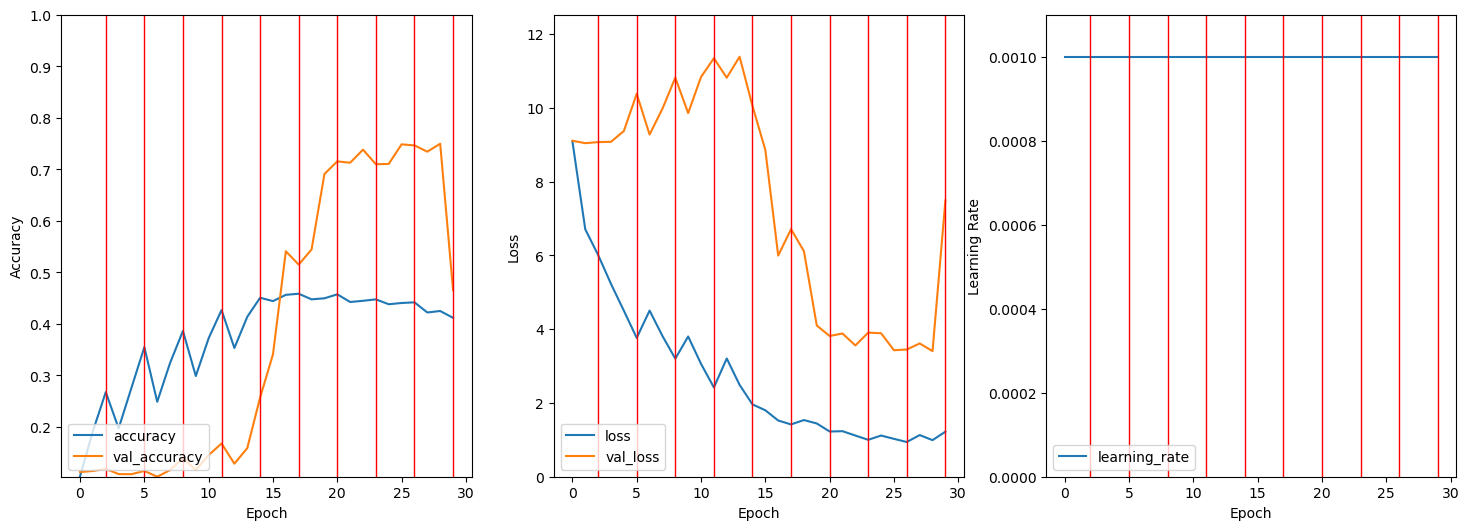

In [10]:
plot_histories(histories)

### Load model from disk to get reproducible results

In [11]:
model = keras.saving.load_model(MODEL_FILE_NAME)

### Evaluate selected puzzles

In [12]:
def prepare_input_batch(puzzle):
    reshaped = preprocess_input(puzzle)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [13]:
def prepare_target_batch(solution):
    reshaped = preprocess_target(solution)
    reshaped_batch = tf.expand_dims(reshaped, axis=0)
    return reshaped_batch

In [14]:
def solve_sudoku(puzzle):
    reshaped_batch = prepare_input_batch(puzzle)
    predictions = model.predict(reshaped_batch)
    result = np.argmax(predictions, axis=-1) + 1 # predictions are 0-based but game starts with 1
    return result

In [15]:
result = solve_sudoku(
    ""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[8 6 3 2 5 9 7 1 4]
 [4 2 5 3 7 9 9 9 8]
 [7 7 3 4 3 8 9 6 5]
 [9 9 6 8 4 5 3 9 6]
 [2 9 4 6 2 3 1 9 8]
 [6 3 7 9 1 1 5 5 3]
 [5 4 8 7 9 9 6 4 1]
 [7 7 3 5 2 1 6 8 9]
 [2 7 9 5 8 6 5 7 1]]


In [16]:
puzzle = (""
    "800250704"
    "420000000"
    "000008065"
    "000045300"
    "004603100"
    "007910000"
    "540700000"
    "000000089"
    "209086001"
)
solution = (""
    "863259714"
    "425167938"
    "791438265"
    "612845397"
    "984673152"
    "357912846"
    "548791623"
    "176324589"
    "239586471"
)

accuracy, loss, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))

W0000 00:00:1746551916.749723  263654 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746551916.752817  263654 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6049 - box_penalty: 0.0914 - col_penalty: 0.0885 - loss: 4.6094 - row_penalty: 0.0793


In [17]:
result = solve_sudoku(""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
).reshape((9,9))

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[4 2 9 5 1 9 6 3 7]
 [1 5 6 1 4 7 9 2 9]
 [3 7 6 6 2 6 9 4 1]
 [1 3 5 9 6 1 4 3 4]
 [6 2 9 4 8 4 2 1 5]
 [6 1 4 7 5 2 9 6 8]
 [2 6 2 1 7 5 1 9 3]
 [5 8 1 3 4 4 7 8 4]
 [7 4 3 1 9 8 5 5 2]]


In [18]:
puzzle = (""
"400510607"
"050007020"
"300020041"
"035960000"
"600400015"
"014002008"
"060075093"
"001000700"
"703098052"
)

solution = (
    ""
    "482519637"
    "156347829"
    "379826541"
    "835961274"
    "627483915"
    "914752368"
    "268175493"
    "591234786"
    "743698152"
)

loss, accuracy, *rest = model.evaluate(prepare_input_batch(puzzle), prepare_target_batch(solution))
accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7160 - box_penalty: 0.0798 - col_penalty: 0.0657 - loss: 3.8435 - row_penalty: 0.0871


0.7160493731498718

### Evaluate on different difficulties

In [19]:
for index, train_dataset in enumerate(train_datasets):
    batch_count = 10
    total_loss = 0.0
    total_accuracy = 0.0
    total_non_zero_count = 0

    for X_batch, y_batch in train_dataset.take(batch_count):
        y_batch_without_flag = tf.cast(tf.where(y_batch >= 10, y_batch - 10, y_batch), tf.float32)

        loss, accuracy, *rest = model.evaluate(X_batch, y_batch_without_flag, verbose=0)
        total_loss += loss
        total_accuracy += accuracy
        total_non_zero_count += tf.reduce_mean(tf.math.count_nonzero((X_batch + 0.5) * 9, axis=(1, 2)))

    avg_loss = total_loss / batch_count
    avg_accuracy = total_accuracy / batch_count
    print(f"Difficulty {index + 1}: loss={avg_loss}, accuracy={avg_accuracy}")

    avg_non_zero = int(total_non_zero_count / batch_count)
    print(f"Average non-zero numbers in puzzle in one batch: {avg_non_zero}\n")


W0000 00:00:1746551919.498561  263652 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


Difficulty 1: loss=0.5670641511678696, accuracy=0.9771170854568482
Average non-zero numbers in puzzle in one batch: 68

Difficulty 2: loss=2.243735909461975, accuracy=0.8529851496219635
Average non-zero numbers in puzzle in one batch: 47

Difficulty 3: loss=2.552557897567749, accuracy=0.8279513895511628
Average non-zero numbers in puzzle in one batch: 44

Difficulty 4: loss=2.86680588722229, accuracy=0.8028645813465118
Average non-zero numbers in puzzle in one batch: 41

Difficulty 5: loss=3.0160746574401855, accuracy=0.7889081776142121
Average non-zero numbers in puzzle in one batch: 40

Difficulty 6: loss=3.2650309801101685, accuracy=0.767491340637207
Average non-zero numbers in puzzle in one batch: 38

Difficulty 7: loss=3.387882947921753, accuracy=0.7561535537242889
Average non-zero numbers in puzzle in one batch: 37

Difficulty 8: loss=3.603688144683838, accuracy=0.738141405582428
Average non-zero numbers in puzzle in one batch: 35

Difficulty 9: loss=3.6472081422805784, accuracy=

### Evaluate test set performance

In [20]:
loss, accuracy, *rest = model.evaluate(test_dataset)

W0000 00:00:1746551941.336755  263652 assert_op.cc:38] Ignoring Assert operator compile_loss/sudoku_loss/assert_equal_1/Assert/AssertGuard/Assert


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7514 - box_penalty: 0.0727 - col_penalty: 0.0740 - loss: 3.3915 - row_penalty: 0.0751


In [21]:
print(f"On test set, model achieved accuracy: {accuracy} and loss: {loss}")

On test set, model achieved accuracy: 0.7518197894096375 and loss: 3.3905458450317383


### Evaluate after replacing fixed positions with fixed numbers

In [22]:
x_test = []
y_true = []

for X, y in test_dataset:
    x_test.append(X.numpy())
    y_true.append(y.numpy())

x_test = np.concatenate(x_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred = model.predict(x_test)
# predictions are 0-based but puzzle solution numbers start with 1
y_pred_classes = np.argmax(y_pred, axis=-1) + 1

# revert preprocessing so numbers are as in puzzles
x_test_fixed = ((x_test + 0.5) * 9).reshape((-1, 9, 9))
y_true_fixed = y_true + 1

# replace fixed positions in predictions with actual fixed numbers
y_pred_fixed = np.where(x_test_fixed == 0, y_pred_classes, x_test_fixed)

accuracy_metric = keras.metrics.Accuracy()
accuracy_metric.update_state(y_true_fixed, y_pred_fixed)
print(f"Test Set Accuracy: {accuracy_metric.result().numpy():.8f}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Test Set Accuracy: 0.75267267


The End

In [23]:
# TODO: prepare tests (hyperparameters, experiments, save figures, times, etc.)